Automatic detection of solar type III radio bursts

In [33]:
import warnings
warnings.filterwarnings('ignore')
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
from type3detect import detectRadioburst as drb
from type3detect import radioTools as rt

machine = 'dias' # dias or nancep

if machine=='dias': # on dias machines
    data_dir    = '/home/mnedal/data/ORFEES'
    folder_path = '/home/mnedal/data/pkl_files'
    outputs     = '/home/mnedal/data/png'

elif machine=='nancep': # on nancep node
    data_dir    = '/home/mnedal/data'
    folder_path = '/home/mnedal/outputs/data'
    outputs     = '/home/mnedal/outputs/plots'

In [72]:
mydate        = '20250325'
stock_param   = 'stokesI' # stokesI, stokesV_over_I
SRB_groupname = 'typeIII_G3'

# year, month, day = mydate.split('-')

## Load NenuFAR radio dynamic spectrum

In [73]:
nenufar_files = sorted(glob.glob(f'{folder_path}/nenufar/*'))
nenufar_files

['/home/mnedal/data/pkl_files/nenufar/combined_dyspec_20250325_093459_20250325_094159_stokesI_typeIII_G1.pkl',
 '/home/mnedal/data/pkl_files/nenufar/combined_dyspec_20250325_093459_20250325_094159_stokesV_over_I_typeIII_G1.pkl',
 '/home/mnedal/data/pkl_files/nenufar/combined_dyspec_20250325_093459_20250325_094159_stokesV_over_I_typeIII_G1_fullres.pkl',
 '/home/mnedal/data/pkl_files/nenufar/combined_dyspec_20250325_094259_20250325_094900_stokesI_typeIII_G2.pkl',
 '/home/mnedal/data/pkl_files/nenufar/combined_dyspec_20250325_094259_20250325_094900_stokesV_over_I_typeIII_G2.pkl',
 '/home/mnedal/data/pkl_files/nenufar/combined_dyspec_20250325_103529_20250325_104000_stokesI_typeIII_G3.pkl',
 '/home/mnedal/data/pkl_files/nenufar/combined_dyspec_20250325_103529_20250325_104000_stokesV_over_I_typeIII_G3.pkl',
 '/home/mnedal/data/pkl_files/nenufar/combined_dyspec_20250325_104500_20250325_104900_stokesI_typeIII_G4.pkl',
 '/home/mnedal/data/pkl_files/nenufar/combined_dyspec_20250325_104500_202503

In [74]:
fname = [ file for file in nenufar_files if mydate in file.split('/')[-1] and stock_param in file.split('/')[-1] and SRB_groupname in file.split('/')[-1] ][0]
print(fname)

df_nenufar = pd.read_pickle(fname)
df_nenufar.head(3)

/home/mnedal/data/pkl_files/nenufar/combined_dyspec_20250325_103529_20250325_104000_stokesI_typeIII_G3.pkl


Frequency,21.627808,21.725464,21.823120,21.920776,22.018433,22.116089,22.213745,22.311401,22.409058,22.506714,...,83.151245,83.248901,83.346558,83.444214,83.541870,83.639526,83.737183,83.834839,83.932495,84.030151
Time,,,,,,,,,,,,,,,,,,,,,
2025-03-25 10:35:29.996050,2.858156e+09,2.429282e+10,5.743880e+08,2.653022e+08,4.472863e+08,2.405993e+08,3.703162e+09,2.624106e+08,3.737964e+08,1.943116e+08,...,8.623014e+06,8.941651e+06,8.041256e+06,8.342881e+06,7.531242e+06,7.536527e+06,6.913398e+06,7.105575e+06,6.486888e+06,6.476511e+06
2025-03-25 10:35:30.017021,2.277195e+09,2.640836e+10,6.473780e+08,2.830134e+08,4.684768e+08,2.535491e+08,3.732681e+09,2.909263e+08,3.535151e+08,1.873688e+08,...,8.585717e+06,8.964588e+06,8.084590e+06,8.205584e+06,7.467824e+06,7.810682e+06,6.966383e+06,7.142348e+06,6.594846e+06,6.441522e+06
2025-03-25 10:35:30.037993,2.246453e+09,2.477880e+10,7.214789e+08,2.731197e+08,4.596565e+08,2.485077e+08,3.618905e+09,3.010054e+08,3.600770e+08,1.909101e+08,...,8.947768e+06,9.020036e+06,8.132530e+06,8.325576e+06,7.530124e+06,7.636989e+06,7.142470e+06,7.043341e+06,6.261917e+06,6.579038e+06


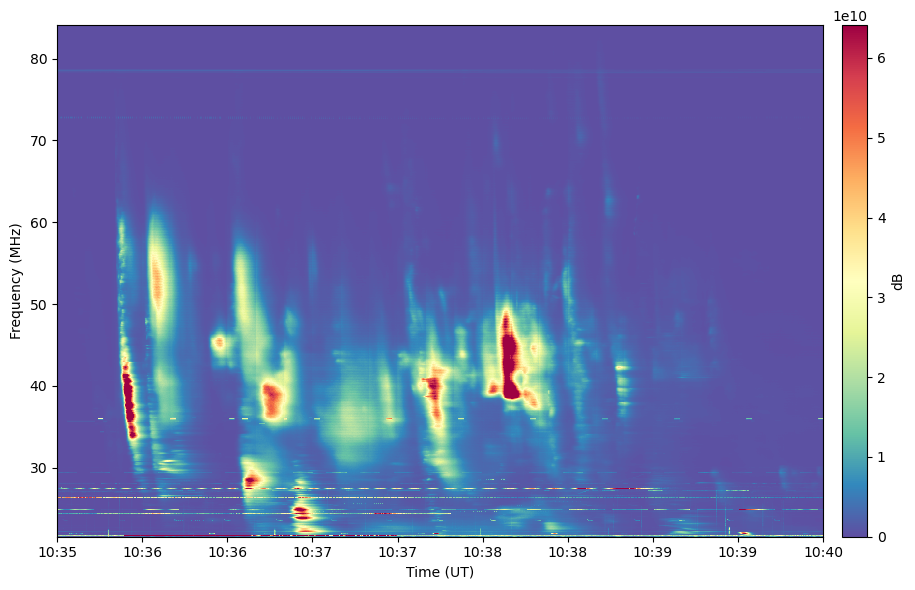

In [78]:
fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(df_nenufar.index, df_nenufar.columns, df_nenufar.T,
                   vmin=0, vmax=np.nanpercentile(df_nenufar, 99.7), cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

## Remove the constant background

In [79]:
nenufar_nobkg = df_nenufar - np.tile(np.nanmedian(df_nenufar,0), (df_nenufar.shape[0],1))

In [77]:
# vmin = np.nanmin( np.nanmedian(nenufar_nobkg) - 10*np.nanstd(nenufar_nobkg) )
# vmax = np.nanmax( np.nanmedian(nenufar_nobkg) + 10*np.nanstd(nenufar_nobkg) )
# print(f'vmin={vmin:.2e}, vmax{vmax:.2e}')

In [90]:
vmin, vmax = np.nanpercentile(nenufar_nobkg, [10, 99.7])
print(f'vmin={vmin:.2e}, vmax{vmax:.2e}')

vmin=-2.12e+09, vmax5.90e+10


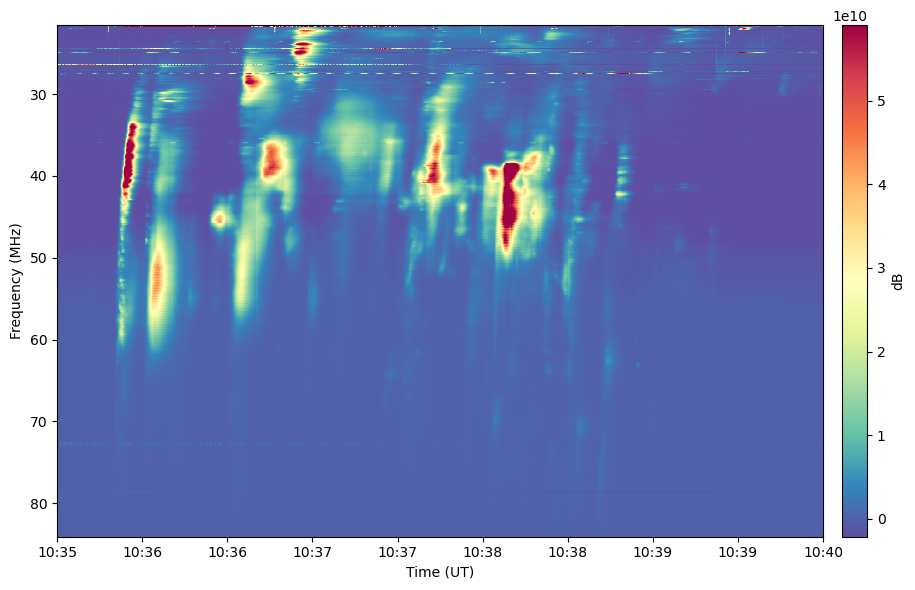

In [91]:
fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(nenufar_nobkg.index, nenufar_nobkg.columns, nenufar_nobkg.T,
                   vmin=vmin, vmax=vmax, cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_ylim(ax.get_ylim()[::-1])  # Reverse Y axis for frequency descending
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

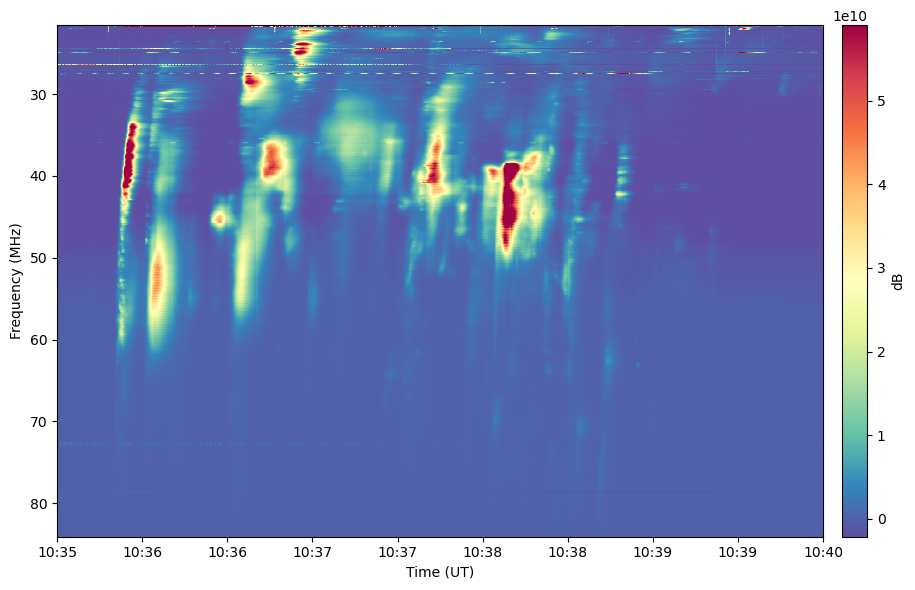

In [100]:
nenufar_nobkg.clip(lower=vmin, upper=vmax, inplace=True)

# # sanity check ...
# fig = plt.figure(figsize=[10,6])
# ax = fig.add_subplot(111)
# pc = ax.pcolormesh(nenufar_nobkg.index, nenufar_nobkg.columns, nenufar_nobkg.T, cmap='Spectral_r')
# fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
# ax.set_xlabel('Time (UT)')
# ax.set_ylabel('Frequency (MHz)')
# ax.set_ylim(ax.get_ylim()[::-1])  # Reverse Y axis for frequency descending
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# fig.tight_layout()
# plt.show()

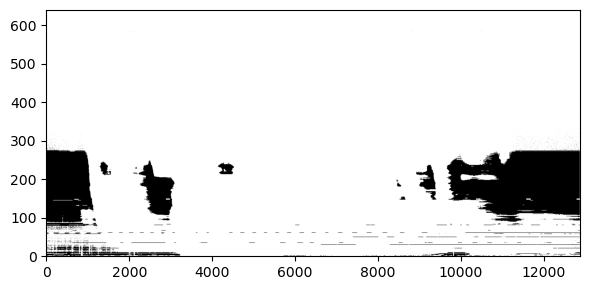

In [107]:
# binarization
bmap = drb.binarization(nenufar_nobkg, N_order=6, peak_r=1.002)

fig, ax = plt.subplots(1, 1, figsize=[6,3])
ax.imshow(1-bmap.T, aspect='auto', origin='lower', cmap='gray')
fig.tight_layout()
plt.show()

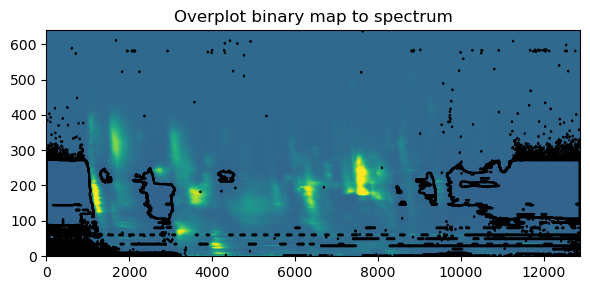

In [108]:
fig,ax = plt.subplots(1, 1, figsize=[6,3])
ax.imshow(nenufar_nobkg.T, aspect='auto', origin='lower', vmax=vmax, vmin=vmin/2-vmax/2)
ax.contour(bmap.T, [0,0.5,1], colors='k')
ax.set_title('Overplot binary map to spectrum')
fig.tight_layout()
plt.show()

In [109]:
# detect verticle features
lines = drb.hough_detect(bmap, nenufar_nobkg, threshold=40, line_gap=10, line_length=35,
            theta=np.linspace(np.pi/2-np.pi/8, np.pi/2-1/180*np.pi, 300))

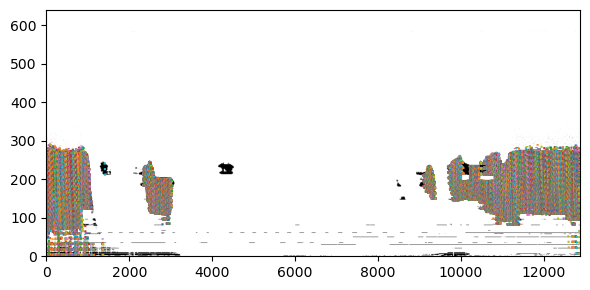

In [110]:
fig, ax = plt.subplots(1, 1, figsize=[6,3])
lines = sorted(lines, key=lambda i: i[0][1])
ax.imshow(1-bmap.T, aspect='auto', origin='lower', cmap='gray')

for line in lines:
    p0, p1 = line
    ax.plot( (p0[1],p1[1]), (p0[0],p1[0]), ':')

fig.tight_layout()
plt.show()

In [111]:
# group the detected lines into group in regard of events
line_sets = drb.line_grouping(lines)

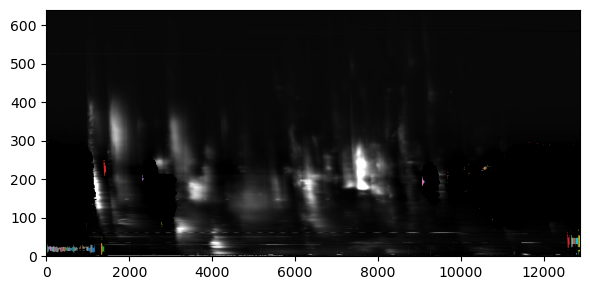

In [112]:
fig, ax = plt.subplots(1,1,figsize=[6,3])
ax.imshow(nenufar_nobkg.T, aspect='auto', origin='lower', vmax=vmax, vmin=vmin, cmap='gray')

for idx,lines in enumerate(line_sets):
    for line in lines:
        p0, p1 = line
        ax.plot( (p0[1],p1[1]), (p0[0],p1[0]), color='C'+str(idx+1))
        ax.plot( (p0[1],p1[1]), (p0[0],p1[0]), 'k+', zorder=10)

fig.tight_layout()
plt.show()

In [113]:
# Select a subset of frequencies (e.g., 10 evenly spaced ones)
num_curves = 10
frequencies = nenufar_nobkg.columns.sort_values()
selected_freqs = frequencies[::len(frequencies)//num_curves]

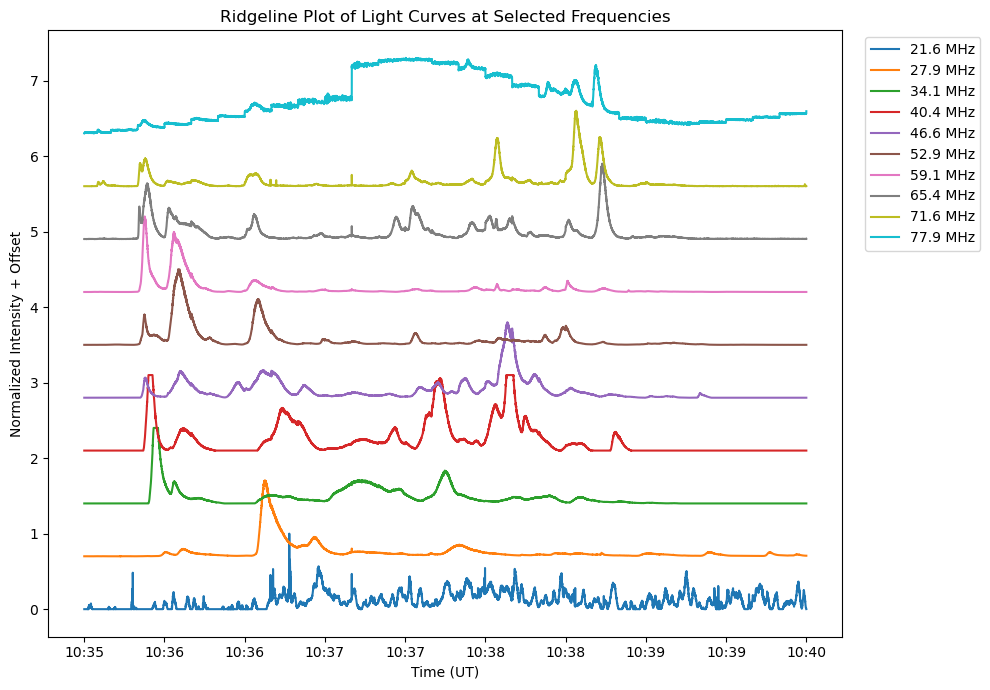

In [127]:
fig, ax = plt.subplots(figsize=[10,7])

offset  = 0
spacing = 0.7  # Vertical spacing between curves

for i, freq in enumerate(selected_freqs):
    curve = nenufar_nobkg[freq]
    times = nenufar_nobkg.index
    
    # Normalize each curve (optional for better visual comparison)
    curve_norm = (curve - curve.min()) / (curve.max() - curve.min())
    
    ax.plot(times, curve_norm+offset, label=f'{freq:.1f} MHz')
    offset += spacing

ax.set_xlabel('Time (UT)')
ax.set_ylabel('Normalized Intensity + Offset')
ax.set_title('Ridgeline Plot of Light Curves at Selected Frequencies')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

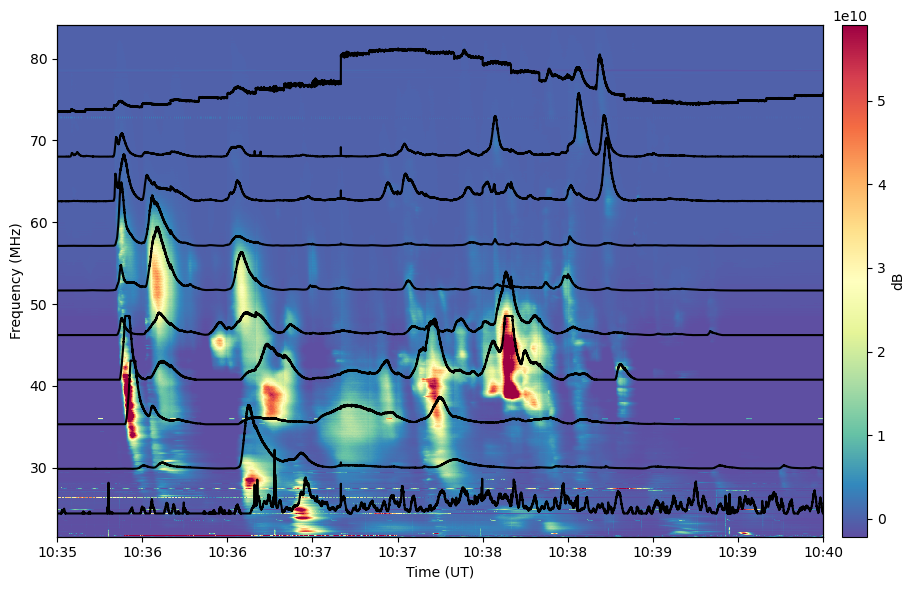

In [135]:
fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)

# --- Dynamic spectrum ---
pc = ax.pcolormesh(
    nenufar_nobkg.index, 
    nenufar_nobkg.columns, 
    nenufar_nobkg.T, 
    cmap='Spectral_r'
)
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')

# --- Overlay normalized light curves ---
offset  = 0
spacing = 0.7  # Vertical spacing between curves
ax2 = ax.twinx()

for i, freq in enumerate(selected_freqs):
    curve = nenufar_nobkg[freq]
    times = nenufar_nobkg.index
    
    # Normalize each curve (optional for better visual comparison)
    curve_norm = (curve - curve.min()) / (curve.max() - curve.min())
    
    ax2.plot(times, curve_norm+offset, color='k', label=f'{freq:.1f} MHz')
    offset += spacing

# --- Remove right y-axis ticks and label ---
ax2.set_yticks([])

# --- Axis formatting ---
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

fig.tight_layout()
plt.show()

In [139]:
df_nenufar = pd.read_pickle(fname)

In [140]:
from scipy.ndimage import median_filter

background = df_nenufar.apply(lambda x: median_filter(x, size=100), axis=0)
df_denoised = df_nenufar - background

# Detect bursts as deviations from median (in dB)
threshold = df_denoised.mean().mean() + 3 * df_denoised.std().mean()
df_thresh = df_denoised > threshold

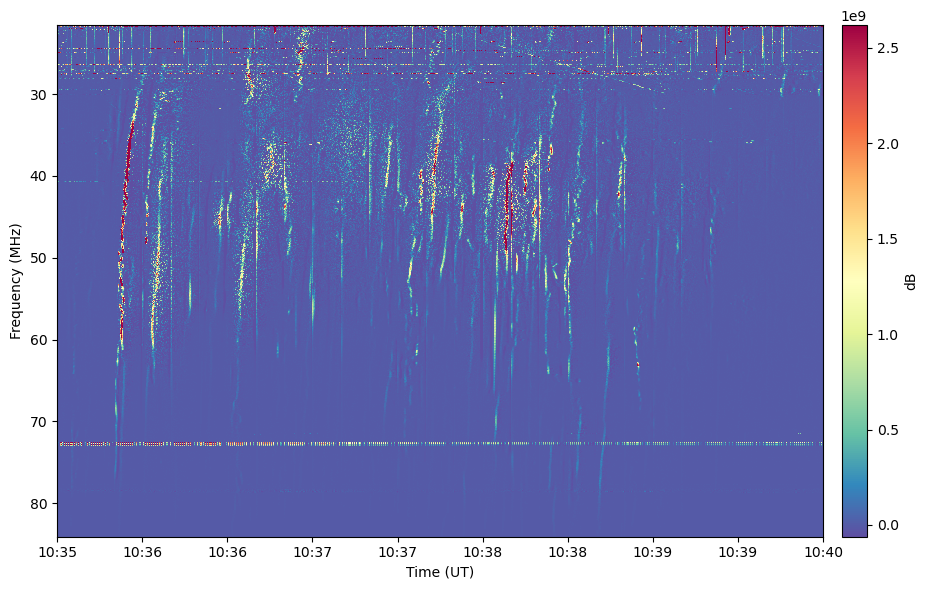

In [144]:
vmin, vmax = np.nanpercentile(df_denoised, [10, 99.7])

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(df_denoised.index, df_denoised.columns, df_denoised.T,
                   vmin=vmin, vmax=vmax,
                   cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_ylim(ax.get_ylim()[::-1])  # Reverse Y axis for frequency descending
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

In [145]:
from scipy.ndimage import label

# Convert boolean DataFrame to 2D array
mask = df_thresh.values.astype(int)
labeled_array, num_features = label(mask)

In [151]:
from sklearn.linear_model import LinearRegression

type_iii_bursts = []

for label_id in range(1, num_features + 1):
    coords = np.argwhere(labeled_array == label_id)
    if coords.shape[0] < 10:
        continue  # Ignore small features

    times = df_nenufar.index[coords[:, 0]].astype(np.int64) // 10**9  # Convert to seconds
    freqs = df_nenufar.columns[coords[:, 1]].astype(float)

    # Linear regression to estimate frequency drift
    model = LinearRegression().fit(times.to_numpy().reshape(-1, 1), freqs)
    drift_rate = model.coef_[0]

    if drift_rate < -0.1:  # negative drift in MHz/s
        type_iii_bursts.append({
            "start_time": df_nenufar.index[min(coords[:, 0])],
            "end_time": df_nenufar.index[max(coords[:, 0])],
            "start_freq": freqs.min(),
            "end_freq": freqs.max(),
            "drift_rate": drift_rate,
        })

In [152]:
pd.DataFrame(type_iii_bursts)

,start_time,end_time,start_freq,end_freq,drift_rate
0,2025-03-25 10:35:51.575747,2025-03-25 10:35:53.106668,49.948120,50.924683,-0.363991
1,2025-03-25 10:35:52.204890,2025-03-25 10:35:53.337354,57.077026,60.494995,-0.395156
2,2025-03-25 10:35:52.288776,2025-03-25 10:35:53.840668,44.674683,47.994995,-0.572834
3,2025-03-25 10:35:53.316383,2025-03-25 10:35:57.594570,32.369995,42.916870,-2.621117
4,2025-03-25 10:36:03.403681,2025-03-25 10:36:04.284488,33.834839,35.690308,-0.322812
5,2025-03-25 10:36:03.550482,2025-03-25 10:36:04.200602,54.830933,56.491089,-0.239439
6,2025-03-25 10:36:04.871690,2025-03-25 10:36:05.647634,51.803589,53.854370,-0.142453
7,2025-03-25 10:36:05.542776,2025-03-25 10:36:06.088036,48.092651,49.948120,-0.137094
8,2025-03-25 10:36:14.434701,2025-03-25 10:36:15.420365,21.627808,25.143433,-1.547885
9,2025-03-25 10:36:34.798049,2025-03-25 10:36:35.343309,50.729370,52.877808,-0.240922


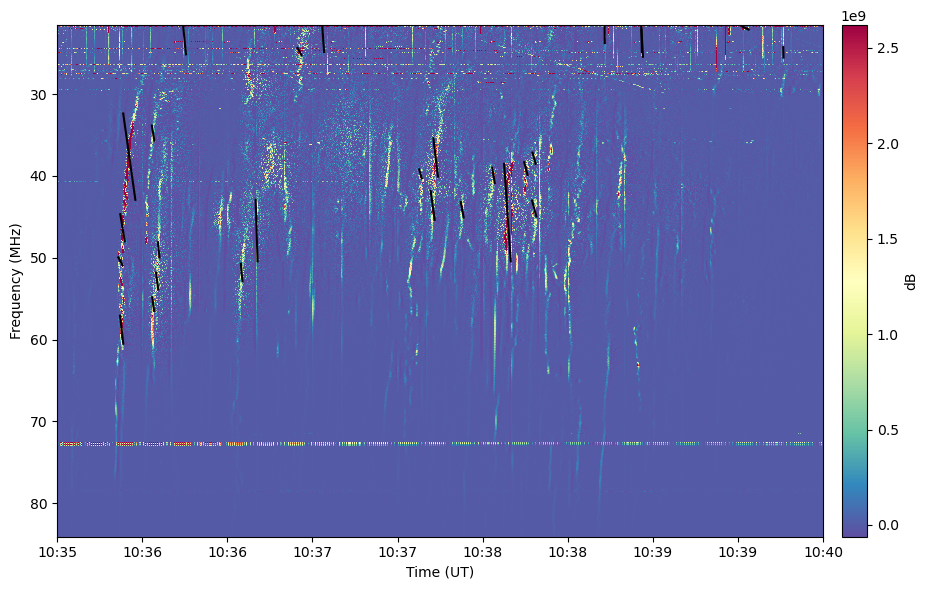

In [154]:
vmin, vmax = np.nanpercentile(df_denoised, [10, 99.7])

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(df_denoised.index, df_denoised.columns, df_denoised.T,
                   vmin=vmin, vmax=vmax,
                   cmap='Spectral_r')

for burst in type_iii_bursts:
    ax.plot([burst['start_time'], burst['end_time']],
             [burst['start_freq'], burst['end_freq']], color='k')

fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_ylim(ax.get_ylim()[::-1])  # Reverse Y axis for frequency descending
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
from skimage.feature import canny
from skimage.transform import probabilistic_hough_line

# ---------------------------
# 1.  Background removal
# ---------------------------
df = df_nenufar.copy()                               # your dB dynamic spectrum
background = df.apply(lambda x: median_filter(x, size=150), axis=1)
df_denoised = df - background

# ---------------------------
# 2.  Build image (freq rows, time cols)
# ---------------------------
img = df_denoised.T.values                           # shape = (N_freq, N_time)
img = (img - img.min()) / (img.max() - img.min())    # normalise to [0,1]

# ---------------------------
# 3.  Edge detection
# ---------------------------
edges = canny(img, sigma=2)                          # σ≈2 works well for NenuFAR

# ---------------------------
# 4.  Probabilistic Hough
# ---------------------------
lines = probabilistic_hough_line(
    edges,
    threshold=8,          # min votes
    line_length=25,       # ≥ 25 px → ignore speckle
    line_gap=4            # allow small gaps
)

# ---------------------------
# 5.  Convert pixels → phys. coords & filter
# ---------------------------
time_values = df.index.to_numpy()
freq_values = df.columns.astype(float).to_numpy()

def pixel_to_coords(p):                # p = (row, col)
    row, col = p
    f = freq_values[row]               # MHz
    t = time_values[col]               # numpy.datetime64
    return t, f

type_iii_bursts = []
for (p0, p1) in lines:
    t0, f0 = pixel_to_coords(p0)
    t1, f1 = pixel_to_coords(p1)

    # drift rate in MHz s⁻¹
    dt = (t1 - t0) / np.timedelta64(1, 's')
    if dt == 0:
        continue
    drift = (f1 - f0) / dt

    # keep only fast downward drifts
    if drift < -0.5:
        burst = dict(
            start_time=min(t0, t1),
            end_time=max(t0, t1),
            start_freq=max(f0, f1),
            end_freq=min(f0, f1),
            drift_rate_MHz_per_s=drift
        )
        type_iii_bursts.append(burst)

# ---------------------------
# 6.  Plot for sanity-check
# ---------------------------
plt.figure(figsize=(10, 6))
plt.imshow(img, aspect='auto', origin='lower',
           extent=[0, len(time_values), freq_values[0], freq_values[-1]])
for b in type_iii_bursts:
    x0 = np.where(time_values == b['start_time'])[0][0]
    x1 = np.where(time_values == b['end_time'])[0][0]
    plt.plot([x0, x1], [b['start_freq'], b['end_freq']], 'r-', lw=2)
plt.xlabel("Time index")
plt.ylabel("Frequency (MHz)")
plt.title("Type III candidates via Hough transform")
plt.tight_layout()
plt.show()

# ---------------------------
# 7.  Put results in a DataFrame
# ---------------------------
type_iii_df = pd.DataFrame(type_iii_bursts)
display(type_iii_df)